# Elevation Cleaning

# Imports

In [8]:
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.features import geometry_mask
from rasterio.plot import show
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from shapely.geometry import box, mapping
from shapely.ops import Point
from tqdm import tqdm
import pyproj
import math
from shapely.ops import LineString
import pickle
import contextily as cx

# from whittaker_eilers import WhittakerSmoother

import src.elevation_tools as elevation_tools

import sys
sys.path.insert(0,str(Path.cwd().parent))
import file_structure_setup
config = file_structure_setup.filepaths()

## Import non-network version of osm

In [9]:
#import network
links = gpd.read_file(config['osmdwnld_fp'] / f"osm_{config['geofabrik_year']}.gpkg",layer='raw')

## Reproject network to DEM crs

In [10]:
dem_urls = elevation_tools.get_dem_urls(links)
dem_crs = rasterio.open(dem_urls[0]).crs
links.to_crs(dem_crs,inplace=True)

## Import sampled elevation data

In [11]:
#for storing the interpolated points with sampled elevation data
with (config['network_fp']/'elevation.pkl').open('rb') as fh:
    interpolated_points_dict = pickle.load(fh)

# Selected Examples

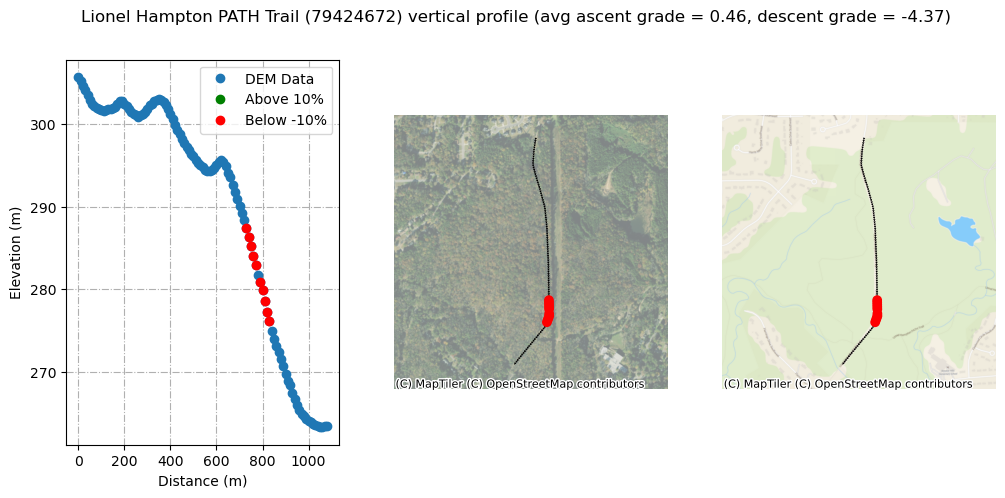

In [16]:
linkid = 79424672
grade_threshold = 10
elevation_tools.visualize(links,dem_crs,interpolated_points_dict,[linkid],grade_threshold,None,config['maptilerapikey'],one_off=True)

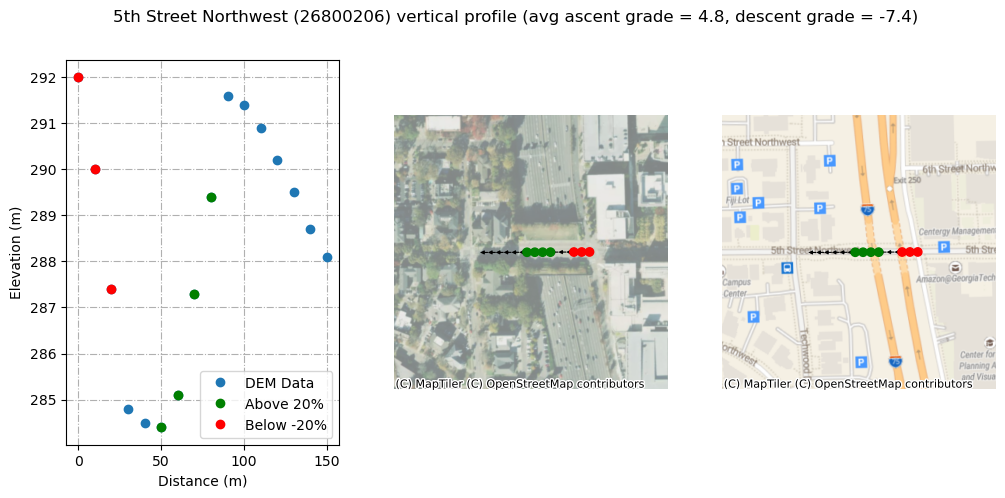

In [12]:
linkid = 26800206
grade_threshold = 20
elevation_tools.visualize(links,dem_crs,interpolated_points_dict,[linkid],grade_threshold,None,config['maptilerapikey'],one_off=True)

Local road that I know has steep grades:

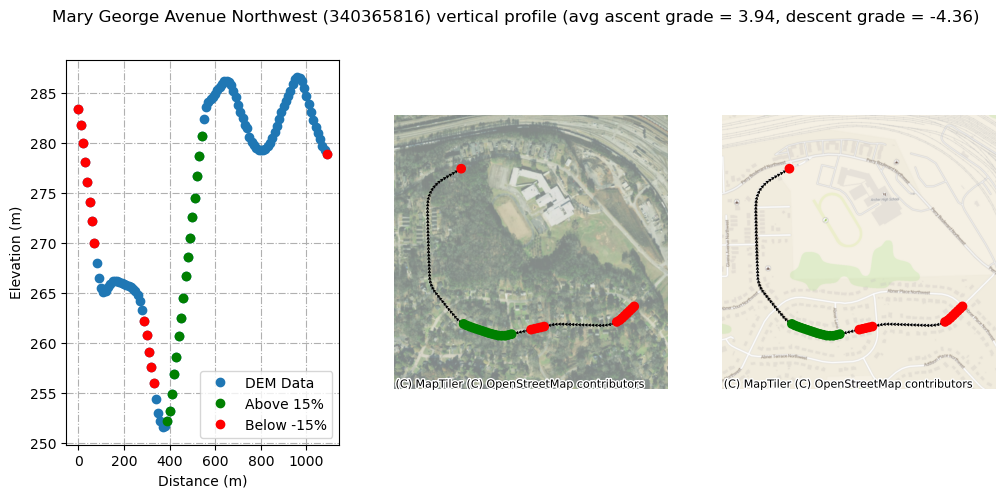

In [13]:
linkid = 340365816
grade_threshold = 15
elevation_tools.visualize(links,dem_crs,interpolated_points_dict,[linkid],grade_threshold,None,config['maptilerapikey'],one_off=True)

Northside Drive as "tertiary" road with a small segment above 15%

In [6]:
# linkid = 352003174
# grade_threshold = 15
# elevation_tools.visualize(links,dem_crs,interpolated_points_dict,[linkid],grade_threshold,None,config['maptilerapikey'],one_off=True)

In [7]:
# linkid = 44097075
# grade_threshold = 30
# elevation_tools.visualize(links,dem_crs,interpolated_points_dict,[linkid],grade_threshold,None,config['maptilerapikey'],one_off=True)

BeltLine

In [8]:
# linkid = 226119768
# grade_threshold = 15
# elevation_tools.visualize(links,dem_crs,interpolated_points_dict,[linkid],grade_threshold,None,config['maptilerapikey'],one_off=True)

In [9]:
# linkid = 741964053
# grade_threshold = 30
# elevation_tools.visualize(links,dem_crs,interpolated_points_dict,[linkid],grade_threshold,None,config['maptilerapikey'],one_off=True)

Circular golf course loop

In [10]:
# linkid = 1087991070
# elevation_tools.visualize(links,dem_crs,interpolated_points_dict,[linkid],grade_threshold,None,config['maptilerapikey'],one_off=True)

# Point Knockout
- Calculate segment grade changes using the sampling distance
- Define a segment grade threshold by OSM highway type (e.g., motorway, local, secondary, etc.)
    - Highways/Interstates > 8%
    - Most local roads > 15%
    - Few local roads > 25%
- Knockout all grade changes that exceed threshold
- Repeat until no grade changes are above threshold
    - If this removes too many points 
- Spline fit on the remaining data for the interpolation step

Hongyu Method:
- Find first grade change (ascent or descent) exceeding threshold
- Search 30m, 100m, or 150m after and find the last opposite grade change exceeding threshold
- Remove first to last point
- Infill with the spline fit



## Define Grade Thresholds

In [11]:
grade_thresholds = {
    'tunnel': 8,
    'bridge': 8,
    'motorway': 8,
    'local': 20,
    'ped': 30,
    'exclude': 30
}

In [12]:
#initialize the label field
links['label'] = None

#tunnel
links.loc[links['tunnel'].notna() & links['label'].isna(),'label'] = 'tunnel'

#bridge
links.loc[links['bridge'].notna() & links['label'].isna(),'label'] = 'bridge'

#motorway/major arterials
motorway = ['motorway','motorway_link',
            'trunk', 'trunk_link',
            'primary','primary_link',
            'secondary','secondary_link',
            'raceway', 'proposed']
links.loc[links['highway'].isin(motorway) & links['label'].isna(),'label'] = 'motorway'

#local/service roads
local = ['tertiary','tertiary_link','residential','service', 'unclassified','living_street']
links.loc[links['highway'].isin(local) & links['label'].isna(),'label'] = 'local'

#pedestrian paths/steps may not follow grade thresholds
ped = ['path','footway','track','pedestrian','cycleway','platform']
links.loc[links['highway'].isin(ped) & links['label'].isna(),'label'] = 'ped'

#label everything else as exclude or place a high value
links.loc[links['label'].isna(),'label'] = 'exclude'


In [13]:
for label, grade_threshold in grade_thresholds.items():
    #identify links with grades exceeding the threshold
    labelled_links = links.loc[links['label']==label,'osmid'].tolist()
    exceeds = elevation_tools.exceeds_threshold(labelled_links,interpolated_points_dict,grade_threshold)
    print(len(exceeds),'/',len(interpolated_points_dict),label,'links exceed the threshold')
    #for the links that exceed the threshold, do point knockout
    for linkid in tqdm(exceeds):
        item = interpolated_points_dict.get(linkid,0)
        #TODO have a before after measure to jusdge quality
        #before = len(item['elevations'])
        elevation_tools.point_knockout(item,grade_threshold)
        interpolated_points_dict[linkid] = item


2 / 60908 tunnel links exceed the threshold


100%|██████████| 2/2 [00:00<00:00, 66.14it/s]


53 / 60908 bridge links exceed the threshold


100%|██████████| 53/53 [00:00<00:00, 97.79it/s] 


7 / 60908 motorway links exceed the threshold


100%|██████████| 7/7 [00:00<00:00, 187.44it/s]


4 / 60908 local links exceed the threshold


100%|██████████| 4/4 [00:00<00:00, 167.20it/s]


0 / 60908 ped links exceed the threshold


0it [00:00, ?it/s]


0 / 60908 exclude links exceed the threshold


0it [00:00, ?it/s]


# Spline Fit
For all the links, fit a spline for the next step.

In [14]:
#spline fit
import numpy as np
from scipy.interpolate import splrep, splev, BSpline

too_short = [ ]

for key, item in tqdm(interpolated_points_dict.items()):
    df = pd.DataFrame({'distance':item['distances'],'elevation':item['elevations']})

    #remove na values
    df = df[df.notna().all(axis=1)]

    #in this case, just do linear interpolation between the two values
    if df.shape[0] <= 3:
        too_short.append(key)
        continue

    #fit a spline
    spline = splrep(df['distance'], df['elevation'], s=0.5)

    #add spline to dict
    interpolated_points_dict[key]['spline'] = spline

100%|██████████| 60908/60908 [00:51<00:00, 1175.11it/s]


In [15]:
# 9245034 goes under a railraod track

In [16]:
# # Add a check here
# import random

# osmid = 751119047#random.choice(list(interpolated_points_dict.keys()))
# item = interpolated_points_dict[osmid]

# spline = item.get('spline',0)
# xs = item.get('distances',0)
# elevations = item.get('elevations',0)

# #get new elevation values
# new_xs = np.arange(0,xs[-1],1)
# new_elevations = splev(new_xs, spline)

# fig, ax = plt.subplots()
# ax.plot(xs,elevations,'-')
# ax.plot(new_xs,new_elevations,'-.')

In [17]:
with (config['network_fp'] / "spline_fit_elevation.pkl").open('wb') as fh:
    pickle.dump(interpolated_points_dict,fh)

# Move on to step 7

<!-- ## Find underpasses/tunnels and knockout elevated segments
- Should have a distinct section that's high above everything else
- Need to also bring in railroads
- Can also be tagged as tunnels
# #grab ones that are not bridges and don't exceed the threshold
# not_bridges = exceeds_threshold.loc[exceeds_threshold['bridge'].isna(),['id','geometry']]
# print(len(not_bridges),'of thse are not tagged as bridges')
# bridges = links.loc[~links['bridge'].isna(),['id','geometry']]
Check if bridge crosses non-bridge (won't include where a link connects to a bridge)

# crossing_links = []
# for idx, row in bridges.iterrows():
#     bridge = row['geometry']
#     crosses = not_bridges.loc[not_bridges.crosses(bridge),'id'].tolist()
#     if len(crosses) > 0:
#         crossing_links = crossing_links + crosses
# mask = list(set(crossing_links))

## Smooth with [Whittaker-Eilers Method](https://towardsdatascience.com/the-perfect-way-to-smooth-your-noisy-data-4f3fe6b44440)

Need fitted function for interpolation
# for linkid, item in interpolated_points_dict.items():
    
#     distances = np.array(item['distances'])
    
#     if linkid in lidar_found:
#         elevations = np.array(item['lidar'])
#     else: 
#         elevations = np.array(item['elevations'])

#     whittaker_smoother = WhittakerSmoother(
#     lmbda=150, order=2, data_length=len(elevations)
#     )

#     smoothed = whittaker_smoother.smooth(elevations)

#     output = elevation_tools.elevation_stats(distances,smoothed,grade_threshold)

#     #assign new entry in the dictionary
#     interpolated_points_dict[linkid].update({
#         'smoothed': smoothed,
#         'smoothed_ascent': output['ascent'],
#         'smoothed_descent': output['descent'], 
#         'smoothed_ascent_grade': output['ascent_grade'],
#         'smoothed_descent_grade': output['descent_grade'],
#         'smoothed_bad_ascent_grades': output['bad_ascent_grades'],
#         'smoothed_bad_descent_grades': output['bad_descent_grades'],
#         'smoothed_segment_grades': output['segment_grades']
#     })

# #for storing the interpolated points with sampled elevation data
# with (export_fp/'smoothed_elevation.pkl').open('wb') as fh:
#     pickle.dump(interpolated_points_dict,fh)
## Measuring Grade
Length of grade + grade matters. Grade is change in elevation over a length of road. 
- Grade can be averaged over the entire link (seperating up and down)
- Grade can be averaged over the just the section of up or down (expected grade going uphill)
- Grade can be categorized (>3%, >6,% >10,etc) and the length in each category could be calculated

If we're just concerned about the impact on travel time then an average value is probably fine, but if we're more concerned about a preference then categorizing and finding the lengths of each is probably more useful.

In route choice literature, they're either look at the average grade of the entire route (Hood 2011, Prato 2018) or break it into categories (proportion of the route 2-4% grade) (Broach 2012). Since we're estimating link level impedances, we can be flexible and avoid taking averages if desired.

Broach:
- 2-4%
- 4-6%
- more than 6% -->